In [163]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [164]:
df = pd.read_csv('E:/training.1600000.processed.noemoticon.csv', encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [165]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [166]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [167]:
df.duplicated().sum()

16309

In [168]:
df.drop_duplicates(inplace=True)

In [169]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [170]:
df.rename(columns={'sentiment': 'label'}, inplace=True)
df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [171]:
df = df.replace(4, 1)
print(df.loc[1200000])

label                                                    1
text     danielle is the best thing since cheese in a c...
Name: 1200000, dtype: object


In [172]:
remove_n = 1500000
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df = df.drop(drop_indices)

In [173]:
print("Size:", len(df))

Size: 83691


Text(0.5, 1.0, 'Sarcasm Data Distribution')

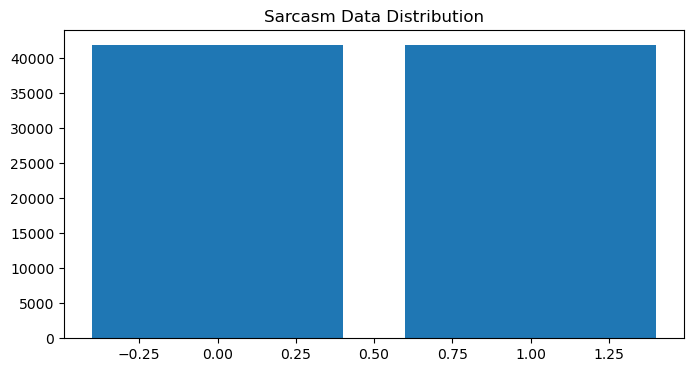

In [174]:
val_count = df.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sarcasm Data Distribution")

# Split & Train

In [188]:
import tensorflow as tf
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import Dataset
import evaluate

In [176]:
sentences = df['text']
label = df['label']

In [177]:
TRAIN_SIZE = 0.8

In [178]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 66952
Test Data size 16739


In [179]:
hg_train_data = Dataset.from_pandas(train_data)
hg_test_data = Dataset.from_pandas(test_data)

In [225]:
print(hg_test_data)

Dataset({
    features: ['label', 'text', '__index_level_0__'],
    num_rows: 16739
})


In [180]:
tokenizer_path = './sentiment_tokenizer_transformer/'
sentiment_model_path = './sentiment_trainer_transformer/'
sarcasm_model_path = './sarcasm_trainer_transformer/'

In [181]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

In [182]:
def tokenize(data):
   return tokenizer(data["text"], max_length=30, truncation=True, padding="max_length")
 
train_data = hg_train_data.map(tokenize)
test_data = hg_test_data.map(tokenize)

Map:   0%|          | 0/66952 [00:00<?, ? examples/s]

Map:   0%|          | 0/16739 [00:00<?, ? examples/s]

In [189]:
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_path, num_labels=2)

In [221]:
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    # probabilities = tf.nn.softmax(logits)
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [222]:
trainer = Trainer(
    model=sentiment_model,
    compute_metrics=compute_metrics,
)

In [223]:
print(test_data)

Dataset({
    features: ['label', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 16739
})


In [224]:
trainer.predict(test_data)

  0%|          | 0/2093 [00:00<?, ?it/s]

PredictionOutput(predictions=array([[ 0.09866653, -0.24385358],
       [-1.3072414 ,  1.2400979 ],
       [ 1.0770714 , -0.9565274 ],
       ...,
       [-1.2454203 ,  1.2503864 ],
       [ 0.19604154, -0.12375699],
       [-0.7765476 ,  0.47655556]], dtype=float32), label_ids=array([0, 0, 0, ..., 1, 1, 0], dtype=int64), metrics={'test_loss': 0.42147788405418396, 'test_accuracy': 0.8260947487902504, 'test_runtime': 284.1666, 'test_samples_per_second': 58.906, 'test_steps_per_second': 7.365})

In [226]:
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    logits = 1 - logits
    #for logit in logits:
    #    logit
    # probabilities = tf.nn.softmax(logits)
    predictions = np.argmax(logits, axis=1)
    print(predictions)
    return metric.compute(predictions=predictions, references=labels)

In [227]:
trainer = Trainer(
    model=sentiment_model,
    eval_dataset=test_data,
    compute_metrics=compute_metrics,
)

In [228]:
trainer.predict(test_data)

  0%|          | 0/2093 [00:00<?, ?it/s]

[1 0 1 ... 0 1 0]


PredictionOutput(predictions=array([[ 0.09866653, -0.24385358],
       [-1.3072414 ,  1.2400979 ],
       [ 1.0770714 , -0.9565274 ],
       ...,
       [-1.2454203 ,  1.2503864 ],
       [ 0.19604154, -0.12375699],
       [-0.7765476 ,  0.47655556]], dtype=float32), label_ids=array([0, 0, 0, ..., 1, 1, 0], dtype=int64), metrics={'test_loss': 0.42147788405418396, 'test_accuracy': 0.17390525120974967, 'test_runtime': 343.5294, 'test_samples_per_second': 48.727, 'test_steps_per_second': 6.093})

import pickle
with open(r'E:/Research ML/LSTM_SarcasmDetection.pkl', 'wb') as file:  
    pickle.dump(model, file)